In [1]:
from scipy.io import loadmat
import numpy as np
import sympy as sim
import scipy as sp
import math
import matplotlib.pyplot as plt
import SolveTriangular as st

## Esame Metodi Numerici  10 gennaio 2025 - Ore 14

Si considerino i due sistemi lineari:

     A  x = b 

    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incogniti da determinare.
I dati di questi due sistemi lineari sono contenuti nel file **test.mat**.


- Si risolva ciascuno dei sistemi lineari assegnati  utilizzato il metodo più adatto in base alle caratteristiche della matrice dei coefficienti, giustificando teoricamente le scelte effettuate.
                                      **punti 5**

Per il primo sistema lineare A x= b,  aggiungere una perturbazione dell' 1% sulla componente b[0]  del termine noto, e risolvere il sistema con termine noto perturbato. Calcolare quindi  l'errore relativo sulla soluzione e l'errore relativo sui dati e giustificare i risultati alla luce della teoria, richiamando il teorema relativo.
                                      **punti 3**


Per la lettura dei dati procedere nel seguente modo:

In [19]:
dati = loadmat('test')
A=dati["A"]
A=A.astype(float)
b=dati["b"]
b=b.astype(float)
A1=dati["A1"]
A1=A1.astype(float)
b1=dati["b1"]
b1=b1.astype(float)

In [82]:
def is_square(A):
    return A.shape[0]==A.shape[1]

def condition(A):
    return np.linalg.cond(A)

def is_symmetric(A):
    return np.all(A.T==A)

def is_diag_dominant(A):
    absA=np.abs(A)
    return np.all(2*np.diag(absA)>=np.sum(absA,axis=1))

def is_pos_def(A):
    eig=np.linalg.eigvals(A)
    return np.all(eig>0)

def print_size(A):
    print('Size: {}x{}'.format(A.shape[0],A.shape[1]))

def density_perc(A):
    return np.count_nonzero(A)/(A.shape[0]*A.shape[1])*100

In [85]:
print('MATRICE A')
print('Dimensioni?')
print_size(A)
print('Condizionamento:',condition(A))
print('Densità : {}%'.format(density_perc(A)))
print('Diagonale Dominante? ', is_diag_dominant(A))
print('Simmetrica?', is_symmetric(A))
print('Definita positiva?', is_pos_def(A))
# Utilizzo il teorema della convergenza del metodo di gauss seidel che dice che se una matrice è simmetrica e definita positiva,
# Allora il metodo converge
print('MATRICE A1')
print('Dimensioni?')
print_size(A1)
print('Condizionamento:',condition(A1))
print('Rango massimo?: ',np.linalg.matrix_rank(A1)==A1.shape[0])

# Poichè la matrice A1 non è a rango massimo, è sovradeterminata e altamente malcondizionata, utilizzo il metodo SVDLQ
# Che è "resistente" a matrici altamente mal condizionate e è l'unico che trova una soluzione con una matrice non a rango massimo.

MATRICE A
Dimensioni?
Size: 20x20
Condizionamento: 9999.999999997885
Densità : 8.0%
Diagonale Dominante?  False
Simmetrica? True
Definita positiva? True
MATRICE A1
Dimensioni?
Size: 20x15
Condizionamento: 5.697438059606206e+16
Rango massimo?:  False


In [86]:
def gauss_seidel(A,b,x0,toll,it_max):
    errore=1000
    d=np.diag(A)
    D=np.diag(d)
    E=np.tril(A,-1)
    F=np.triu(A,1)
    M=D+E
    N=-F

    # Convergence check
    invM=np.linalg.inv(M)
    T=invM@N
    eigenvalues=np.linalg.eigvals(T)
    spectralradius=np.max(np.abs(eigenvalues))
    # print("raggio spettrale Gauss-Seidel ",raggiospettrale)

    # print("Norm:", np.linalg.norm(T,2))
    
    it=0
    er_vet=[]
    while it<=it_max and errore>=toll:
        x,flag=st.Lsolve(M,b+N@x0) # Key Operation
        errore=np.linalg.norm(x-x0)/np.linalg.norm(x)
        er_vet.append(errore)
        x0=x.copy()
        it=it+1
    return x,it,er_vet

In [96]:
def SVDLS(A,b):
    m,n=A.shape  #numero di righe e  numero di colonne di A
    U,s,VT=sp.linalg.svd(A)  #Attenzione : Restituisce U, il numpy-array 1d che contiene la diagonale della matrice Sigma e VT=VTrasposta)
    #Quindi 
    V=VT.T
    thresh=np.spacing(1)*m*s[0] ##Calcolo del rango della matrice, numero dei valori singolari maggiori di una soglia
    k=np.count_nonzero(s>thresh)
    print("rango=",k)
    d=U.T@b
    d1=d[:k].reshape(k,1)
    s1=s[:k].reshape(k,1)
        
    #Risolve il sistema diagonale di dimensione kxk avene come matrice dei coefficienti la matrice Sigma
    c=d1/s1
    x=V[:,:k]@c
    residuo=np.linalg.norm(d[k:])**2
    return x,residuo

In [78]:
def conjugateGradient(A,b,x0,itmax,tol):
    
    x=x0.copy()
    r=A@x-b
    p=-r
    it=0
    normb=np.linalg.norm(b)
    errore=np.linalg.norm(r)/normb
    
    vec_sol=[]
    vec_sol.append(x.copy())
    vec_r=[]
    vec_r.append(errore)

    while errore>=tol and it<itmax:
        it=it+1
        
        Ap=A@p

        save=(r.T@r)
        alpha=save/(Ap.T@p)
        
        x=x+alpha*p
        r=r+alpha*Ap

        vec_sol.append(x.copy())
        errore=np.linalg.norm(r)/normb
        vec_r.append(errore)

        gamma=(r.T@r)/save
        p=-r+gamma*p # Max descent (Opposite of gradient)
        
    iterates=np.vstack([arr.T for arr in vec_sol]) # Only for graphical purpose

    return x,vec_r, iterates, it

In [90]:
def QRsolve(A,b):
    Q,R=sp.linalg.qr(A)
    y=Q.T@b
    x,flag=st.Usolve(R,y)
    
    return x    

In [80]:
def solveCholesky(A,b):
    L=sp.linalg.cholesky(A,lower=True)
    y,flag=st.Lsolve(L,b)
    if flag==0:
        x,flag=st.Usolve(L.T,y)
    return x

In [95]:
x0=np.zeros_like(b)

toll=1e-10
it_max=10000
x,it,er_vet=gauss_seidel(A,b,x0,toll, it_max)
xchol=solveCholesky(A,b)
xqr=QRsolve(A,b)
x1np=np.linalg.lstsq(A,b)

x1,residuo=SVDLS(A1,b1)
print('xgauss',x,'it',it)
print('xchol',xchol)
print('xqr',xqr)
xg,vecr,iters,it=conjugateGradient(A,b,x0,200,1e-10)
print('xgradient',xg)
print(x1)
print(x1np)

xgauss [[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.00000012]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999995]] it 4733
xchol [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
xqr [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
xgradient [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.5210993 ]
 [1.25827182]
 [1.27889527]
 [0.46087355]
 [0.89024294]
 [1.04762977]
 [0.29616227]
 [0.59585228]
 [1.13383321]
 [0.94430646]
 [1.32127485]
 [0.97301581]
 [0.15568769]
 [0.79644108]
 [1.09968922]]
(array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
     

- Dato il sistema lineare 
A3 x3 = b3
dove 

A3=np.array([[8,0,1],[0,12,2],[1,2,-14.0]])
b3= np.array([9.0, 14.0,  -11.0])

- Verificare senza calcolare il raggio spettrale della matrice di iterazione che il metodo di Gauss-Seidel converge, richiamando il teorema che garantisce la convergenza di Gauss-Seidel per classi particolari di 
matrici     **punti[1]**.
- Implementare il metodo di Gauss-Seidel  e risolvere il sistema lineare A3 x3= b3 con  **punti[3]**.

Totale **Punti 12**

In [58]:
A3=np.array([[8,0,1],[0,12,2],[1,2,-14.0]])
b3= np.array([9.0, 14.0,  -11.0]).reshape(3,1)
x03=np.zeros_like(b3)
# Il metodo di Gauss-Seidel converge se la matrice è a diagonale strettamente dominante:
# |a_ii|>sum_ij  j!=i  |a_ij|
A3abs=np.abs(A3)
isDiagDominant=np.all(2*np.diag(A3abs)>np.sum(A3abs,axis=1))
#print(np.sum(A3abs,axis=1))
#print(2*np.diag(A3abs))
print(isDiagDominant)
x3,it3,ervet3=gauss_seidel(A3,b3,x03,toll,it_max)
print(x3)

True
[[1.]
 [1.]
 [1.]]


# Esercizio 2

Implementare le function necessarie per costruire il polinomio interpolante di Lagrange. 
                                       **[4 punti]**
                                                         

In [59]:
def plagr(xnodi,j):
    
    xzeri=np.zeros_like(xnodi)
    n=xnodi.size
    
    xzeri=np.append(xnodi[:j],xnodi[j+1:])
    
    num=np.poly(xzeri)
    den=np.polyval(num,xnodi[j])
    
    p=num/den
    
    return p



def InterpL(x, y, xx):
     
     n=x.size
     m=xx.size
     L=np.zeros((m,n))
     for j in range(n) :
        p=plagr(x,j)
        L[:,j]=np.polyval(p,xx)
     
     return L@y

Sia assegnata la funzione $f(x)=cos(\pi x)+sin(\pi x)$, $ x \in [0,2]$,
facendo uso delle functions implementate precedentemente, si determini il polinomio p che interpola f nei nodi  x0 = 1, x1 = 1.5, x2 = 1.75 e si rappresenti in uno stesso grafico la funzione f, il polinomio p e i punti di interpolazione assegnati;
                                          **[2 punti]**

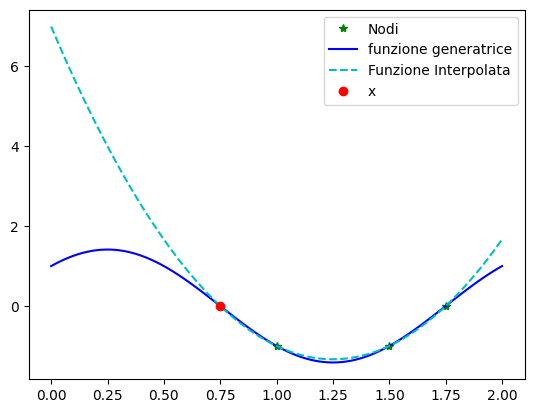

In [72]:
f=lambda x: np.cos(np.pi*x)+np.sin(np.pi*x)
nodes=np.array([1,1.5,1.75])
y=f(nodes)

xv=np.linspace(0,2,100)

g=InterpL(nodes,y,xv)
plt.plot(nodes,y,'g*',xv,f(xv),'b-',xv,g,'c--', 0.75, f(0.75),'ro')
plt.legend(['Nodi','funzione generatrice','Funzione Interpolata','x'])

 si calcoli il valore assunto dalla funzione errore E(x) := |f(x) − p(x)| nel punto $x^∗$ = 0.75 e si definisca teoricamente da cosa dipende l'errore che si compie quando al posto del polinomio interpolatore si considera la funzione che ha generato i dati, commentando opportunamente la formula 
                                                             **[3 punti]**

In [73]:
xs=InterpL(nodes,y,np.array([0.75]))
Ex=np.abs(f(0.75)-xs)

L'errore dipende dai seguenti fattori:
$E(x)=|f(x)-p(x)|=\frac{1}{(n+1)!}\omega(px)*f^{(n+1)}(\epsilon)$
dove $\omega$ è il prodotto della differenza fra il valore $x$ e ogni punto di interpolazione $x_k$
Si nota che la funzione di errore si annulla anche nel caso quando la derivata $n+1$ esima si annulli.

si stabilisca qual è il polinomio interpolatore per f passante per i nodi $x^*$ 
, x0, x1 e x2.   **[1 punto]**

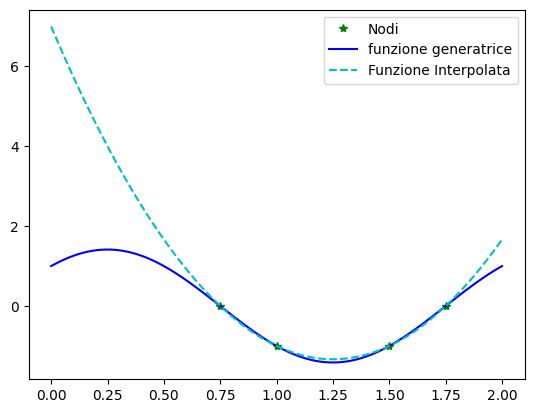

In [75]:
nodes2=np.array([0.75,1,1.5,1.75])
y2=f(nodes2)

g2=InterpL(nodes2,y2,xv)

plt.plot(nodes2,y2,'g*',xv,f(xv),'b-',xv,g,'c--')
plt.legend(['Nodi','funzione generatrice','Funzione Interpolata'])

Si calcoli la costante di Lebesgue per il problema di interpolazione in esame  e si dica che ruolo svolge nell'ambito dell'interpolazione polinomiale
                               **[3 punti]**

In [76]:
# Costante di Lebesgue:
# x=np.array([j for j in range(len(nodes2))])
# np.max(np.sum(np.abs(np.polyval(plagr(nodes2,x),???)))

$\max_{x\in [a,b]}\sum_{j=0}^n |L_i(x)|$

Totale **Punti 13**

## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta:  +0.5 punti, ogni risposta errata: -0.5 punti. La mancanza di risposta:  0 punti**

**Risolvere un problema mediante Machine Learning significa**:
- Fornire alla macchina i dati affinchè impari da sola a risolvere il problema x
- Fornire alla macchina solo dati etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina solo dati non etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina le esatte istruzioni per risolvere il problema
edizione

**2  A cosa serve il validation set?**

-  A trovare i migliori iperparametri del modello

-  Ad addestrare il modello

-  A testare il modello

-  A trovare le etichette dei dati di input

**3  Una classica rete CNN è solitamente composta da:**

· Layer convolutivi seguiti da layer di pooling, flatten layer e neuroni completamente connessi

· Layer di pooling seguiti da layer convolutivi, flatten layer e neuroni completamente connessi

· Layer convolutivi seguiti da layer di pooling, flatten layer e softmax

· Layer di pooling seguiti da layer convolutivi, flatten layer e softmax

**4 Il livello softmax**
- Trasforma i digits della rete in probabilità
- Trasforma le probabilità della rete in digits
- Normalizza i valori di input della rete
- È indispensabile nel task di regressione
lla rete

**5 Per una rete neurale, l’apprendimento è legato a:**
- 	Minimizzare la funzione obiettivo
- Minimizzare la funzione di attivazione
- 	Massimizzare il valore dei pesi tramite l’algoritmo di back-propagation
- Massimizzare il valore della funzione di training


**Domande Aperte**

**6. Spiega in modo dettagliato come il learning rate influenza la convergenza di una rete neurale durante il training. Quali sono le conseguenze di un learning rate troppo alto o troppo basso nel training di una rete neurale. Descrivi le principali strategie di  aggiornamentodel  learning rate durante il training di una rete neurale.** [punti 1.5]

Un learning rate molto alto, può causare in iniziale abbassamento della funzione costo, ma poi inizia ad aumentere.
Un learning rate alto, raggiunge velocemente un valore migliore di quello iniziale, ma è ancora lontano dai valori ottimali della funzione costo
Un learning rate basso, riesce a minimizzare la funzione costo ma richiede molto più tempo per la convergenza.
Un learning rate buono diminuisce costantemente la funzione costo fino a raggiungere il valore ottimale.
Ci sono 3 principali strategie, tutte seguono lo stesso concetto:
- Inizialmente valori di learning rate alti, diminuendolo passo passo.

> Step Decay

Riduce il learning rate iniziale di un fattore ogni numero predefinito di epoche

> Exponential Decay

Riduce in maniera esponenziale il learning rate.

> Time Decay

Decadimento basato sul tempo, modifica il learning rate iniziale in funzione del numero di iterazioni eseguite.

**7. Descrivi in dettaglio l'algoritmo di discesa del gradiente con momento. Quali sono le motivazioni che hanno portato alla sua introduzione rispetto alla discesa del gradiente standard? Fornisci la formula matematica dell'aggiornamento dei pesi in questo algoritmo e spiega il ruolo del termine di momento** [punti 3]

L'algoritmo di discesa del gradiente con momento consiste nell'aggiungere ad ogni passo il concetto di momentum, lo stesso concetto della fisica.
- Si aggiungono fattori dei valori precedenti.
- Il momentum è una combinazione di velocità al passo precedente e del gradiente corrente.

> Formula Matematica
$$v^{k}=\beta v^{k-1}+\nabla C(w^k)$$

L'aggiornamento dei pesi diventa:
$w^{k+1}=w^{k}+\eta\cdot v^k$

Questo metodo risolve diversi problemi:
- Evita che i pesi rimangano bloccati in un minimo locale o un punto piatto della funzione di costo.
- Richiede un numero limitato di passi prima che l'allenamento sia completo.

Accelera la convergenza e riduce le oscillazioni durante l'allenamento.